In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import amp

import timm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True


Using device: cuda


In [27]:
import pandas as pd

# 1. Load the NIH ChestX-ray14 metadata
df = pd.read_csv("Data_Entry_2017.csv")

# 2. Define all 14 disease classes
all_labels = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

# 3. Convert string labels into 14-length multi-hot vector
def encode_labels(label_str):
    vec = [0] * 14
    if label_str != "No Finding":  # only mark diseases if they exist
        for disease in label_str.split('|'):  # handle multiple diseases
            if disease in all_labels:
                vec[all_labels.index(disease)] = 1
    return vec

df['labels'] = df['Finding Labels'].apply(encode_labels)

# 4. Expand the labels into separate columns
labels_expanded = pd.DataFrame(df['labels'].tolist(), columns=all_labels)
df_clean = pd.concat([df[['Image Index']], labels_expanded], axis=1)

# 5. Save as clean CSV (so we can reuse later)
df_clean.to_csv("labels_clean.csv", index=False)
print("✅ Saved labels_clean.csv with shape:", df_clean.shape)


✅ Saved labels_clean.csv with shape: (112120, 15)


In [28]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),   # small rotations
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.3),              # improve contrast in lungs
    A.CoarseDropout(max_holes=1, hole_height=32, hole_width=32, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),  # EfficientNet normalization
    ToTensorV2(),
])

# Validation transform (no augmentation, only resize + normalize)
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


/tmp/ipykernel_18293/205766993.py:10: UserWarning: Argument(s) 'max_holes, hole_height, hole_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, hole_height=32, hole_width=32, p=0.3),


In [29]:
class ChestXrayDataset(Dataset):
    def __init__(self, file_list, img_dir, labels_csv, transform=None):
        self.img_paths = []
        self.labels = []

        # ---- Load labels from CSV ----
        df = pd.read_csv(labels_csv)
        label_dict = dict(zip(df['Image Index'], df.drop(columns=['Image Index']).values.tolist()))

        # ---- Build dataset using split file ----
        with open(file_list, "r") as f:
            lines = f.readlines()
            for line in lines:
                fname = line.strip().split()[0]

                if fname not in label_dict:
                    raise ValueError(f"No labels found for {fname}")

                # Search inside images_xxx/images folders
                found_path = None
                for subdir in os.listdir(img_dir):
                    subpath = os.path.join(img_dir, subdir, "images", fname)
                    if os.path.exists(subpath):
                        found_path = subpath
                        break

                if found_path is None:
                    raise FileNotFoundError(f"Image {fname} not found in {img_dir}")

                self.img_paths.append(found_path)
                self.labels.append(label_dict[fname])

        self.labels = np.array(self.labels, dtype=np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Failed to load image: {self.img_paths[idx]}")

        # Resize first
        img = cv2.resize(img, (300, 300))

        # Convert grayscale → RGB
        img = np.stack([img, img, img], axis=-1)

        # ---- Apply transform if provided ----
        if self.transform:
            img = self.transform(image=img)["image"]
        else:
            img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label


In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = probs * targets + (1 - probs) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_t * ((1 - p_t) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [31]:
CONFIG = {
    "img_size": 300,         # EfficientNet-B3 input size
    "batch_size": 16,        # we set 16 due to GPU memory
    "num_workers": 6,
    "epochs": 50,
    "lr": 1e-4,
    "checkpoint_dir": "checkpoints",
}
os.makedirs(CONFIG["checkpoint_dir"], exist_ok=True)


In [32]:
from torch.utils.data import DataLoader, WeightedRandomSampler

labels_csv = "labels_clean.csv"

# ---- Create datasets with transforms ----
train_dataset = ChestXrayDataset("train_split.txt", "data", labels_csv, transform=train_transform)
val_dataset   = ChestXrayDataset("val_split.txt", "data", labels_csv, transform=val_transform)

# ---- Weighted Sampler ----
labels = train_dataset.labels
class_counts = labels.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-6)

sample_weights = (labels * class_weights).sum(axis=1)
sample_weights = np.clip(sample_weights, a_min=1e-6, a_max=None)

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

# ---- DataLoaders ----
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],   # 16
    sampler=sampler,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],   # 16
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    persistent_workers=True
)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Train size: 77871, Val size: 8653


In [33]:
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=14)
model = model.to(device).to(memory_format=torch.channels_last)

# ---- Loss ----
criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')

# ---- Optimizer ----
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG["lr"],        # e.g. 1e-4
    weight_decay=1e-4
)

# ---- Scheduler with Warmup ----
from transformers import get_cosine_schedule_with_warmup

total_steps = len(train_loader) * CONFIG["epochs"]
warmup_steps = int(0.1 * total_steps)  # 10% of total steps as warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Scheduler setup: {total_steps} total steps, {warmup_steps} warmup steps")

# ---- AMP scaler ----
scaler = amp.GradScaler("cuda")

# Track best metric (legacy, but we now track AUROC + F1 separately in loop)
best_val_metric = -1


Scheduler setup: 243350 total steps, 24335 warmup steps


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


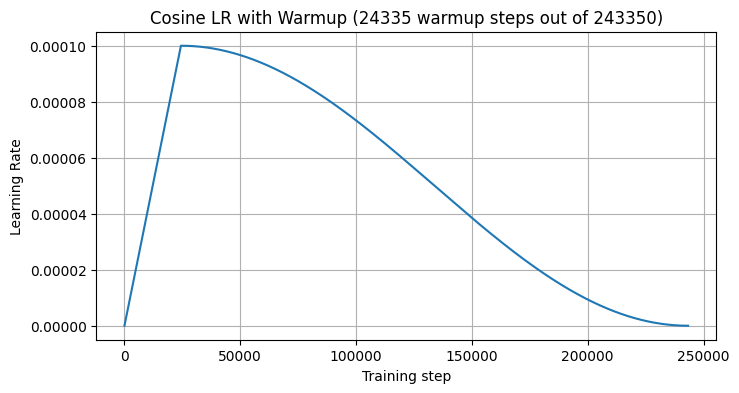

In [34]:
import matplotlib.pyplot as plt

# ---- Simulate LR schedule for plotting ----
lrs = []
model.train()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)

from transformers import get_cosine_schedule_with_warmup
total_steps = len(train_loader) * CONFIG["epochs"]
warmup_steps = int(0.1 * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

for step in range(total_steps):
    lrs.append(scheduler.get_last_lr()[0])  # record current LR
    scheduler.step()

# ---- Plot ----
plt.figure(figsize=(8,4))
plt.plot(lrs)
plt.xlabel("Training step")
plt.ylabel("Learning Rate")
plt.title(f"Cosine LR with Warmup ({warmup_steps} warmup steps out of {total_steps})")
plt.grid(True)
plt.show()


In [35]:
def compute_metrics(y_true, y_probs, threshold=0.5, class_names=None):
    C = y_true.shape[1]
    aucs, aps, f1s = [], [], []
    per_class_metrics = {}

    for c in range(C):
        try:
            auc = roc_auc_score(y_true[:, c], y_probs[:, c])
        except:
            auc = np.nan
        try:
            ap = average_precision_score(y_true[:, c], y_probs[:, c])
        except:
            ap = np.nan

        y_pred_bin = (y_probs[:, c] >= threshold).astype(int)
        f1 = f1_score(y_true[:, c], y_pred_bin, zero_division=0)

        aucs.append(auc)
        aps.append(ap)
        f1s.append(f1)

        if class_names:
            per_class_metrics[class_names[c]] = {
                "auroc": auc,
                "auprc": ap,
                "f1": f1
            }
        else:
            per_class_metrics[c] = {
                "auroc": auc,
                "auprc": ap,
                "f1": f1
            }

    macro_f1 = np.nanmean(f1s)
    micro_f1 = f1_score(y_true, (y_probs >= threshold).astype(int), average='micro', zero_division=0)

    return {
        "auroc_macro": np.nanmean(aucs),
        "ap_macro": np.nanmean(aps),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class": per_class_metrics
    }


# ---- Training Loop ----
best_val_auroc = -1
best_val_f1 = -1
patience = 5
epochs_no_improve = 0

class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")

    # Show current LR
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    # ---- Training ----
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ✅ step scheduler per batch
        scheduler.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss, all_probs, all_targets = 0.0, [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_probs.append(torch.sigmoid(outputs).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)
    metrics = compute_metrics(all_targets, all_probs, class_names=class_names)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"AUROC: {metrics['auroc_macro']:.3f} | AUPRC: {metrics['ap_macro']:.3f} | "
          f"Macro-F1: {metrics['macro_f1']:.3f} | Micro-F1: {metrics['micro_f1']:.3f}")

    # Print a few per-class AUROCs
    print("Sample per-class AUROC:")
    for disease in ["Hernia", "Fibrosis", "Edema"]:
        val = metrics["per_class"][disease]["auroc"]
        print(f"  {disease}: {val:.3f}")

    # ---- Save checkpoint for every epoch ----
    torch.save(model.state_dict(), os.path.join(CONFIG["checkpoint_dir"], f"epoch_{epoch+1}.pth"))

    improved = False

    # ✅ Best by AUROC
    if metrics["auroc_macro"] > best_val_auroc:
        best_val_auroc = metrics["auroc_macro"]
        torch.save(model.state_dict(), os.path.join(CONFIG["checkpoint_dir"], "best_model_auroc.pth"))
        print(f"🌟 Best model updated (AUROC {best_val_auroc:.3f})")
        improved = True

    # ✅ Best by Macro-F1
    if metrics["macro_f1"] > best_val_f1:
        best_val_f1 = metrics["macro_f1"]
        torch.save(model.state_dict(), os.path.join(CONFIG["checkpoint_dir"], "best_model_f1.pth"))
        print(f"🌟 Best model updated (Macro-F1 {best_val_f1:.3f})")
        improved = True

    # ---- Early stopping logic ----
    if improved:
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"⏹ Early stopping triggered after {epoch+1} epochs (no AUROC/F1 improvement for {patience} epochs).")
        break



Epoch 1/50
Current LR: 0.000000


Training:  20%|██        | 997/4867 [01:35<05:50, 11.05it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.2683 | Val Loss: 0.2467 | AUROC: 0.497 | AUPRC: 0.048 | Macro-F1: 0.077 | Micro-F1: 0.082
Sample per-class AUROC:
  Hernia: 0.470
  Fibrosis: 0.505
  Edema: 0.526
🌟 Best model updated (AUROC 0.497)
🌟 Best model updated (Macro-F1 0.077)

Epoch 2/50
Current LR: 0.000000


Train Loss: 0.1503 | Val Loss: 0.0586 | AUROC: 0.511 | AUPRC: 0.049 | Macro-F1: 0.064 | Micro-F1: 0.086
Sample per-class AUROC:
  Hernia: 0.473
  Fibrosis: 0.539
  Edema: 0.552
🌟 Best model updated (AUROC 0.511)

Epoch 3/50
Current LR: 0.000000


Training:  58%|█████▊    | 2828/4867 [04:16<03:07, 10.89it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0578 | Val Loss: 0.0270 | AUROC: 0.542 | AUPRC: 0.054 | Macro-F1: 0.038 | Micro-F1: 0.068
Sample per-class AUROC:
  Hernia: 0.568
  Fibrosis: 0.556
  Edema: 0.669
🌟 Best model updated (AUROC 0.542)

Epoch 4/50
Current LR: 0.000001


Training:  92%|█████████▏| 4462/4867 [06:53<00:36, 10.99it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0428 | Val Loss: 0.0215 | AUROC: 0.590 | AUPRC: 0.064 | Macro-F1: 0.005 | Micro-F1: 0.012
Sample per-class AUROC:
  Hernia: 0.614
  Fibrosis: 0.558
  Edema: 0.782
🌟 Best model updated (AUROC 0.590)

Epoch 5/50
Current LR: 0.000002


Training:  59%|█████▉    | 2874/4867 [04:17<03:07, 10.60it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0368 | Val Loss: 0.0199 | AUROC: 0.661 | AUPRC: 0.091 | Macro-F1: 0.004 | Micro-F1: 0.009
Sample per-class AUROC:
  Hernia: 0.652
  Fibrosis: 0.606
  Edema: 0.826
🌟 Best model updated (AUROC 0.661)

Epoch 6/50
Current LR: 0.000003


Training:  66%|██████▌   | 3202/4867 [04:52<02:30, 11.04it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0344 | Val Loss: 0.0190 | AUROC: 0.720 | AUPRC: 0.124 | Macro-F1: 0.023 | Micro-F1: 0.033
Sample per-class AUROC:
  Hernia: 0.781
  Fibrosis: 0.670
  Edema: 0.850
🌟 Best model updated (AUROC 0.720)

Epoch 7/50
Current LR: 0.000004


Training:  61%|██████    | 2976/4867 [04:30<02:53, 10.93it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0322 | Val Loss: 0.0184 | AUROC: 0.744 | AUPRC: 0.160 | Macro-F1: 0.068 | Micro-F1: 0.071
Sample per-class AUROC:
  Hernia: 0.811
  Fibrosis: 0.713
  Edema: 0.857
🌟 Best model updated (AUROC 0.744)

Epoch 8/50
Current LR: 0.000006


Training:  70%|███████   | 3425/4867 [05:11<02:13, 10.80it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0300 | Val Loss: 0.0183 | AUROC: 0.754 | AUPRC: 0.175 | Macro-F1: 0.100 | Micro-F1: 0.109
Sample per-class AUROC:
  Hernia: 0.829
  Fibrosis: 0.735
  Edema: 0.858
🌟 Best model updated (AUROC 0.754)
🌟 Best model updated (Macro-F1 0.100)

Epoch 9/50
Current LR: 0.000008


Training: 100%|█████████▉| 4852/4867 [07:22<00:01, 10.99it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0280 | Val Loss: 0.0185 | AUROC: 0.754 | AUPRC: 0.181 | Macro-F1: 0.118 | Micro-F1: 0.115
Sample per-class AUROC:
  Hernia: 0.813
  Fibrosis: 0.736
  Edema: 0.847
🌟 Best model updated (Macro-F1 0.118)

Epoch 10/50
Current LR: 0.000010


Training:  86%|████████▌ | 4192/4867 [06:19<01:03, 10.61it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0258 | Val Loss: 0.0185 | AUROC: 0.748 | AUPRC: 0.184 | Macro-F1: 0.149 | Micro-F1: 0.156
Sample per-class AUROC:
  Hernia: 0.797
  Fibrosis: 0.721
  Edema: 0.837
🌟 Best model updated (Macro-F1 0.149)

Epoch 11/50
Current LR: 0.000012


Training:  72%|███████▏  | 3504/4867 [05:17<02:06, 10.81it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0234 | Val Loss: 0.0200 | AUROC: 0.750 | AUPRC: 0.183 | Macro-F1: 0.184 | Micro-F1: 0.204
Sample per-class AUROC:
  Hernia: 0.820
  Fibrosis: 0.725
  Edema: 0.834
🌟 Best model updated (Macro-F1 0.184)

Epoch 12/50
Current LR: 0.000014


Training:  94%|█████████▍| 4575/4867 [06:55<00:27, 10.61it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0207 | Val Loss: 0.0204 | AUROC: 0.739 | AUPRC: 0.179 | Macro-F1: 0.187 | Micro-F1: 0.202
Sample per-class AUROC:
  Hernia: 0.832
  Fibrosis: 0.704
  Edema: 0.821
🌟 Best model updated (Macro-F1 0.187)

Epoch 13/50
Current LR: 0.000017


Training:  89%|████████▉ | 4335/4867 [06:34<00:46, 11.36it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0180 | Val Loss: 0.0218 | AUROC: 0.734 | AUPRC: 0.175 | Macro-F1: 0.197 | Micro-F1: 0.207
Sample per-class AUROC:
  Hernia: 0.825
  Fibrosis: 0.698
  Edema: 0.817
🌟 Best model updated (Macro-F1 0.197)

Epoch 14/50
Current LR: 0.000019


Training:  58%|█████▊    | 2830/4867 [04:15<03:01, 11.22it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0155 | Val Loss: 0.0242 | AUROC: 0.732 | AUPRC: 0.175 | Macro-F1: 0.212 | Micro-F1: 0.239
Sample per-class AUROC:
  Hernia: 0.849
  Fibrosis: 0.683
  Edema: 0.799
🌟 Best model updated (Macro-F1 0.212)

Epoch 15/50
Current LR: 0.000022


Training:  76%|███████▋  | 3715/4867 [05:36<01:44, 11.03it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0133 | Val Loss: 0.0251 | AUROC: 0.732 | AUPRC: 0.175 | Macro-F1: 0.208 | Micro-F1: 0.236
Sample per-class AUROC:
  Hernia: 0.874
  Fibrosis: 0.673
  Edema: 0.802
⚠️ No improvement for 1 epoch(s).

Epoch 16/50
Current LR: 0.000025


Training:  93%|█████████▎| 4533/4867 [06:51<00:30, 10.90it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0115 | Val Loss: 0.0269 | AUROC: 0.726 | AUPRC: 0.172 | Macro-F1: 0.220 | Micro-F1: 0.252
Sample per-class AUROC:
  Hernia: 0.853
  Fibrosis: 0.659
  Edema: 0.782
🌟 Best model updated (Macro-F1 0.220)

Epoch 17/50
Current LR: 0.000028


Training:  96%|█████████▌| 4666/4867 [07:00<00:17, 11.24it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0099 | Val Loss: 0.0267 | AUROC: 0.724 | AUPRC: 0.171 | Macro-F1: 0.208 | Micro-F1: 0.249
Sample per-class AUROC:
  Hernia: 0.824
  Fibrosis: 0.658
  Edema: 0.808
⚠️ No improvement for 1 epoch(s).

Epoch 18/50
Current LR: 0.000031


Training: 100%|█████████▉| 4847/4867 [07:15<00:01, 11.45it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0087 | Val Loss: 0.0288 | AUROC: 0.730 | AUPRC: 0.177 | Macro-F1: 0.222 | Micro-F1: 0.255
Sample per-class AUROC:
  Hernia: 0.885
  Fibrosis: 0.646
  Edema: 0.796
🌟 Best model updated (Macro-F1 0.222)

Epoch 19/50
Current LR: 0.000035


Training:  52%|█████▏    | 2515/4867 [03:47<03:23, 11.55it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0077 | Val Loss: 0.0307 | AUROC: 0.725 | AUPRC: 0.175 | Macro-F1: 0.214 | Micro-F1: 0.266
Sample per-class AUROC:
  Hernia: 0.834
  Fibrosis: 0.674
  Edema: 0.790
⚠️ No improvement for 1 epoch(s).

Epoch 20/50
Current LR: 0.000038


Training:  95%|█████████▍| 4613/4867 [06:56<00:23, 11.02it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0069 | Val Loss: 0.0310 | AUROC: 0.727 | AUPRC: 0.179 | Macro-F1: 0.226 | Micro-F1: 0.263
Sample per-class AUROC:
  Hernia: 0.850
  Fibrosis: 0.655
  Edema: 0.803
🌟 Best model updated (Macro-F1 0.226)

Epoch 21/50
Current LR: 0.000041


Training:  44%|████▎     | 2125/4867 [03:11<04:01, 11.35it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0062 | Val Loss: 0.0323 | AUROC: 0.724 | AUPRC: 0.183 | Macro-F1: 0.232 | Micro-F1: 0.276
Sample per-class AUROC:
  Hernia: 0.831
  Fibrosis: 0.670
  Edema: 0.741
🌟 Best model updated (Macro-F1 0.232)

Epoch 22/50
Current LR: 0.000045


Training:  99%|█████████▊| 4805/4867 [07:16<00:05, 10.82it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0056 | Val Loss: 0.0344 | AUROC: 0.728 | AUPRC: 0.182 | Macro-F1: 0.228 | Micro-F1: 0.279
Sample per-class AUROC:
  Hernia: 0.827
  Fibrosis: 0.684
  Edema: 0.777
⚠️ No improvement for 1 epoch(s).

Epoch 23/50
Current LR: 0.000048


Training:  93%|█████████▎| 4519/4867 [06:53<00:33, 10.39it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0053 | Val Loss: 0.0333 | AUROC: 0.737 | AUPRC: 0.185 | Macro-F1: 0.226 | Micro-F1: 0.284
Sample per-class AUROC:
  Hernia: 0.879
  Fibrosis: 0.684
  Edema: 0.793
⚠️ No improvement for 2 epoch(s).

Epoch 24/50
Current LR: 0.000052


Training:  87%|████████▋ | 4236/4867 [06:29<00:56, 11.17it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0049 | Val Loss: 0.0342 | AUROC: 0.740 | AUPRC: 0.186 | Macro-F1: 0.246 | Micro-F1: 0.283
Sample per-class AUROC:
  Hernia: 0.876
  Fibrosis: 0.692
  Edema: 0.789
🌟 Best model updated (Macro-F1 0.246)

Epoch 25/50
Current LR: 0.000055


Training:  75%|███████▍  | 3629/4867 [05:30<01:54, 10.77it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0045 | Val Loss: 0.0322 | AUROC: 0.732 | AUPRC: 0.178 | Macro-F1: 0.209 | Micro-F1: 0.270
Sample per-class AUROC:
  Hernia: 0.876
  Fibrosis: 0.676
  Edema: 0.794
⚠️ No improvement for 1 epoch(s).

Epoch 26/50
Current LR: 0.000059


Training:  89%|████████▊ | 4315/4867 [06:30<00:53, 10.32it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0043 | Val Loss: 0.0361 | AUROC: 0.736 | AUPRC: 0.184 | Macro-F1: 0.235 | Micro-F1: 0.281
Sample per-class AUROC:
  Hernia: 0.887
  Fibrosis: 0.681
  Edema: 0.767
⚠️ No improvement for 2 epoch(s).

Epoch 27/50
Current LR: 0.000062


Training:  98%|█████████▊| 4767/4867 [07:14<00:09, 10.79it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0040 | Val Loss: 0.0360 | AUROC: 0.728 | AUPRC: 0.178 | Macro-F1: 0.230 | Micro-F1: 0.279
Sample per-class AUROC:
  Hernia: 0.828
  Fibrosis: 0.673
  Edema: 0.775
⚠️ No improvement for 3 epoch(s).

Epoch 28/50
Current LR: 0.000065


Training:  88%|████████▊ | 4289/4867 [06:27<00:52, 11.11it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0038 | Val Loss: 0.0363 | AUROC: 0.729 | AUPRC: 0.182 | Macro-F1: 0.226 | Micro-F1: 0.268
Sample per-class AUROC:
  Hernia: 0.837
  Fibrosis: 0.655
  Edema: 0.765
⚠️ No improvement for 4 epoch(s).

Epoch 29/50
Current LR: 0.000069


Training:  90%|█████████ | 4385/4867 [06:37<00:42, 11.23it/s]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Train Loss: 0.0037 | Val Loss: 0.0382 | AUROC: 0.727 | AUPRC: 0.170 | Macro-F1: 0.218 | Micro-F1: 0.282
Sample per-class AUROC:
  Hernia: 0.838
  Fibrosis: 0.655
  Edema: 0.763
⚠️ No improvement for 5 epoch(s).
⏹ Early stopping triggered after 29 epochs (no AUROC/F1 improvement for 5 epochs).


In [36]:
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_probs, class_names, step=0.01):
    best_thresholds = {}
    best_f1s = {}

    for i, cls in enumerate(class_names):
        best_f1 = 0
        best_t = 0.5
        for t in np.arange(0.05, 0.95, step):
            y_pred_bin = (y_probs[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], y_pred_bin, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds[cls] = best_t
        best_f1s[cls] = best_f1

    return best_thresholds, best_f1s


# ---- Run tuning on validation set ----
model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model_auroc.pth")))
model.eval()

all_probs, all_targets = [], []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Threshold tuning"):
        images = images.to(device, non_blocking=True)
        with amp.autocast("cuda"):
            outputs = model(images)
        all_probs.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

best_thresholds, best_f1s = tune_thresholds(all_targets, all_probs, class_names)

print("\nOptimal thresholds per class:")
for cls in class_names:
    print(f"  {cls}: {best_thresholds[cls]:.2f} (F1={best_f1s[cls]:.3f})")

# ---- Compute new macro-F1 with tuned thresholds ----
y_pred_bin = np.zeros_like(all_probs, dtype=int)
for i, cls in enumerate(class_names):
    y_pred_bin[:, i] = (all_probs[:, i] >= best_thresholds[cls]).astype(int)

macro_f1_tuned = f1_score(all_targets, y_pred_bin, average="macro", zero_division=0)
print(f"\nMacro-F1 with tuned thresholds: {macro_f1_tuned:.3f}")


/tmp/ipykernel_18293/3333571565.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model_auro


Optimal thresholds per class:
  Atelectasis: 0.37 (F1=0.347)
  Cardiomegaly: 0.41 (F1=0.270)
  Effusion: 0.34 (F1=0.488)
  Infiltration: 0.32 (F1=0.304)
  Mass: 0.34 (F1=0.244)
  Nodule: 0.32 (F1=0.149)
  Pneumonia: 0.30 (F1=0.055)
  Pneumothorax: 0.39 (F1=0.288)
  Consolidation: 0.30 (F1=0.198)
  Edema: 0.38 (F1=0.206)
  Emphysema: 0.39 (F1=0.327)
  Fibrosis: 0.32 (F1=0.107)
  Pleural_Thickening: 0.31 (F1=0.125)
  Hernia: 0.60 (F1=0.286)

Macro-F1 with tuned thresholds: 0.243


In [37]:
import torch.nn.functional as F
from torch.optim import LBFGS

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # initial T

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Scale logits by temperature
        return logits / self.temperature

    def set_temperature(self, valid_loader):
        # Collect logits and labels
        self.model.eval()
        logits_list, labels_list = [], []
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Collecting logits for calibration"):
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                logits_list.append(outputs)
                labels_list.append(labels)
        logits = torch.cat(logits_list).to(device)
        labels = torch.cat(labels_list).to(device)

        # NLL loss with sigmoid
        nll_criterion = nn.BCEWithLogitsLoss()

        optimizer = LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss

        optimizer.step(eval)
        print(f"Optimal temperature: {self.temperature.item():.3f}")
        return self

# ---- Apply temperature scaling ----
base_model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=14)
base_model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model_auroc.pth")))
base_model = base_model.to(device)

scaled_model = ModelWithTemperature(base_model).to(device)
scaled_model.set_temperature(val_loader)


/tmp/ipykernel_18293/4165682889.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model

Optimal temperature: 1.426


ModelWithTemperature(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (con

In [38]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, thresholds=None, name=""):
    model.eval()
    all_probs, all_targets = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(labels.numpy())

    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)

    if thresholds is None:  # fixed threshold 0.5
        preds = (all_probs >= 0.5).astype(int)
    else:  # per-class tuned thresholds
        preds = np.zeros_like(all_probs, dtype=int)
        for i, cls in enumerate(class_names):
            preds[:, i] = (all_probs[:, i] >= thresholds[cls]).astype(int)

    # Compute metrics
    metrics = compute_metrics(all_targets, all_probs, class_names=class_names)
    print(f"\n{name} results:")
    print(f"  AUROC (macro): {metrics['auroc_macro']:.3f}")
    print(f"  AUPRC (macro): {metrics['ap_macro']:.3f}")
    print(f"  Macro-F1: {metrics['macro_f1']:.3f}")
    print(f"  Micro-F1: {metrics['micro_f1']:.3f}")

    # Optional: detailed per-class report
    print("\nPer-class F1 summary:")
    print(classification_report(all_targets, preds, target_names=class_names, zero_division=0))
    return metrics


# ---- 1. Raw model ----
raw_model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=14)
raw_model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model_auroc.pth")))
raw_model = raw_model.to(device)

metrics_raw = evaluate_model(raw_model, val_loader, thresholds=None, name="Raw Model (0.5 threshold)")


# ---- 2. Tuned thresholds ----
metrics_tuned = evaluate_model(raw_model, val_loader, thresholds=best_thresholds, name="Tuned Thresholds")


# ---- 3. Calibrated model ----
metrics_calibrated = evaluate_model(scaled_model, val_loader, thresholds=best_thresholds, name="Calibrated Model (Temp Scaling + Tuned Thresholds)")


/tmp/ipykernel_18293/793282906.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model.load_state_dict(torch.load(os.path.join(CONFIG["checkpoint_dir"], "best_model_a


Raw Model (0.5 threshold) results:
  AUROC (macro): 0.754
  AUPRC (macro): 0.175
  Macro-F1: 0.104
  Micro-F1: 0.109

Per-class F1 summary:
                    precision    recall  f1-score   support

       Atelectasis       0.49      0.04      0.08       887
      Cardiomegaly       0.33      0.19      0.24       198
          Effusion       0.74      0.16      0.27       875
      Infiltration       0.43      0.03      0.05      1352
              Mass       0.49      0.05      0.08       395
            Nodule       0.55      0.01      0.03       460
         Pneumonia       0.00      0.00      0.00        98
      Pneumothorax       0.40      0.07      0.12       258
     Consolidation       0.00      0.00      0.00       320
             Edema       0.30      0.08      0.13       131
         Emphysema       0.39      0.16      0.22       161
          Fibrosis       0.11      0.01      0.01       141
Pleural_Thickening       1.00      0.00      0.01       252
            Hernia

Evaluating Tuned Thresholds: 100%|██████████| 541/541 [00:25<00:00, 21.54it/s]



Tuned Thresholds results:
  AUROC (macro): 0.754
  AUPRC (macro): 0.175
  Macro-F1: 0.104
  Micro-F1: 0.109

Per-class F1 summary:
                    precision    recall  f1-score   support

       Atelectasis       0.31      0.41      0.35       887
      Cardiomegaly       0.22      0.31      0.26       198
          Effusion       0.41      0.60      0.49       875
      Infiltration       0.20      0.61      0.30      1352
              Mass       0.21      0.31      0.25       395
            Nodule       0.10      0.24      0.15       460
         Pneumonia       0.03      0.13      0.04        98
      Pneumothorax       0.30      0.28      0.29       258
     Consolidation       0.14      0.33      0.20       320
             Edema       0.16      0.27      0.20       131
         Emphysema       0.31      0.35      0.33       161
          Fibrosis       0.07      0.23      0.11       141
Pleural_Thickening       0.08      0.25      0.12       252
            Hernia       0.

Evaluating Calibrated Model (Temp Scaling + Tuned Thresholds): 100%|██████████| 541/541 [00:25<00:00, 21.30it/s]



Calibrated Model (Temp Scaling + Tuned Thresholds) results:
  AUROC (macro): 0.754
  AUPRC (macro): 0.175
  Macro-F1: 0.104
  Micro-F1: 0.109

Per-class F1 summary:
                    precision    recall  f1-score   support

       Atelectasis       0.22      0.59      0.32       887
      Cardiomegaly       0.19      0.37      0.25       198
          Effusion       0.27      0.79      0.41       875
      Infiltration       0.17      0.91      0.28      1352
              Mass       0.12      0.50      0.19       395
            Nodule       0.07      0.56      0.13       460
         Pneumonia       0.02      0.48      0.04        98
      Pneumothorax       0.20      0.35      0.26       258
     Consolidation       0.08      0.70      0.14       320
             Edema       0.13      0.40      0.19       131
         Emphysema       0.24      0.43      0.31       161
          Fibrosis       0.04      0.53      0.08       141
Pleural_Thickening       0.05      0.61      0.10    

In [39]:
import pandas as pd

# Collect results into a dictionary
results_summary = {
    "Raw (0.5 threshold)": {
        "AUROC (macro)": metrics_raw["auroc_macro"],
        "AUPRC (macro)": metrics_raw["ap_macro"],
        "Macro-F1": metrics_raw["macro_f1"],
        "Micro-F1": metrics_raw["micro_f1"],
    },
    "Tuned Thresholds": {
        "AUROC (macro)": metrics_tuned["auroc_macro"],
        "AUPRC (macro)": metrics_tuned["ap_macro"],
        "Macro-F1": metrics_tuned["macro_f1"],
        "Micro-F1": metrics_tuned["micro_f1"],
    },
    "Calibrated + Tuned": {
        "AUROC (macro)": metrics_calibrated["auroc_macro"],
        "AUPRC (macro)": metrics_calibrated["ap_macro"],
        "Macro-F1": metrics_calibrated["macro_f1"],
        "Micro-F1": metrics_calibrated["micro_f1"],
    }
}

# Convert to DataFrame
df_results = pd.DataFrame(results_summary).T

# Round for clean display
df_results = df_results.round(3)

display(df_results)


,AUROC (macro),AUPRC (macro),Macro-F1,Micro-F1
Raw (0.5 threshold),0.754,0.175,0.104,0.109
Tuned Thresholds,0.754,0.175,0.104,0.109
Calibrated + Tuned,0.754,0.175,0.104,0.109


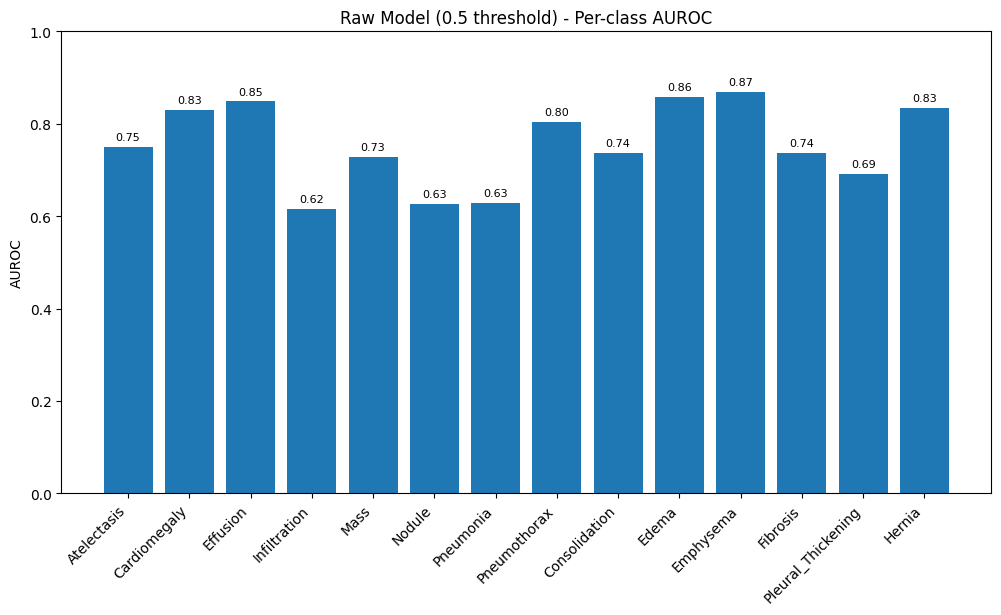

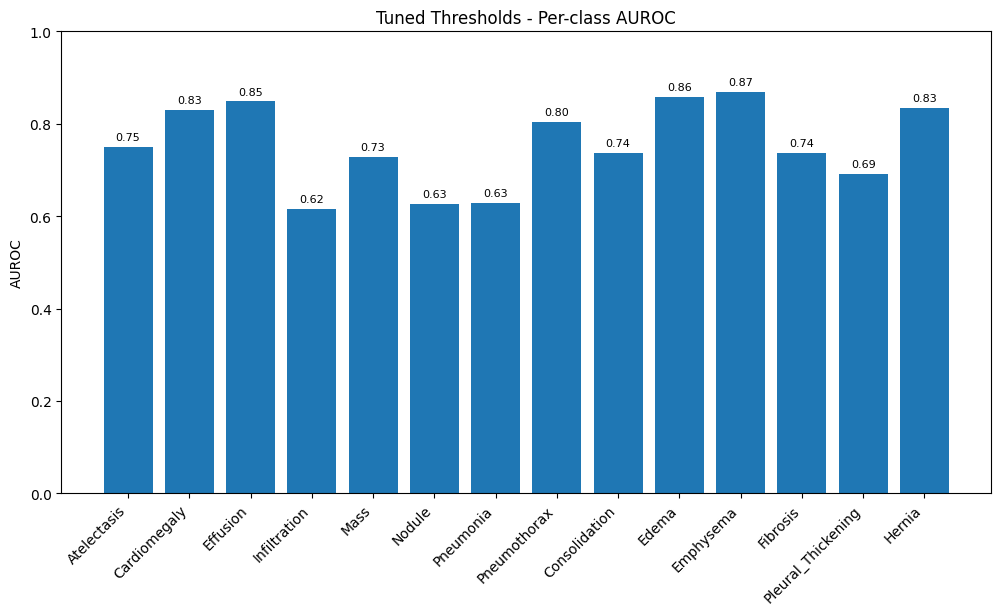

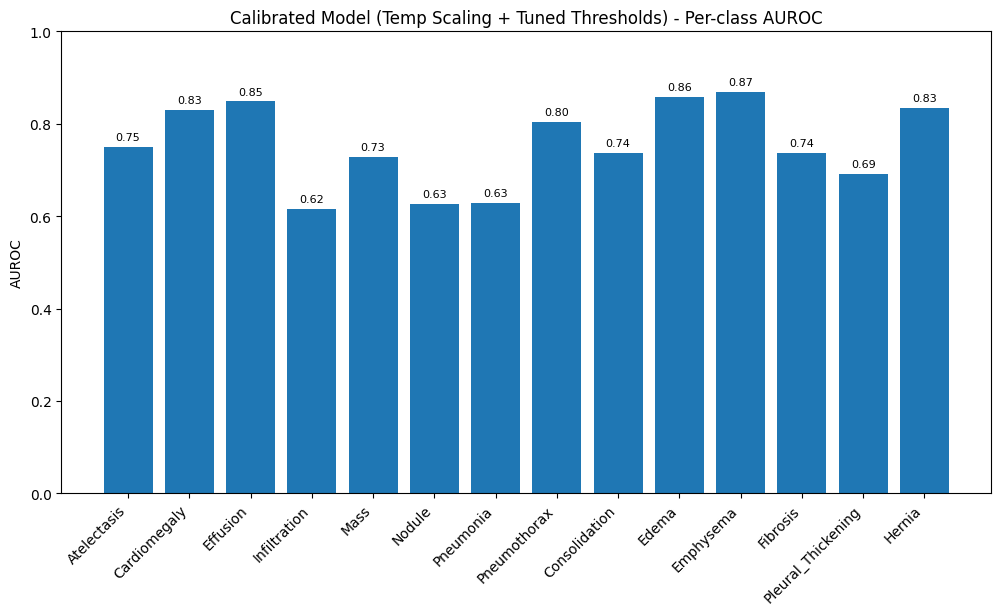

In [40]:
import matplotlib.pyplot as plt

def plot_per_class_auroc(metrics, title="Per-class AUROC"):
    per_class = metrics["per_class"]
    classes = list(per_class.keys())
    aurocs = [per_class[c]["auroc"] for c in classes]

    plt.figure(figsize=(12,6))
    bars = plt.bar(range(len(classes)), aurocs)
    plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.ylabel("AUROC")
    plt.title(title)

    # Annotate bars with values
    for bar, value in zip(bars, aurocs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{value:.2f}", ha="center", va="bottom", fontsize=8)

    plt.show()


# ---- Plot AUROC for each evaluation stage ----
plot_per_class_auroc(metrics_raw, "Raw Model (0.5 threshold) - Per-class AUROC")
plot_per_class_auroc(metrics_tuned, "Tuned Thresholds - Per-class AUROC")
plot_per_class_auroc(metrics_calibrated, "Calibrated Model (Temp Scaling + Tuned Thresholds) - Per-class AUROC")


PR curves data: 100%|██████████| 541/541 [00:25<00:00, 21.59it/s]


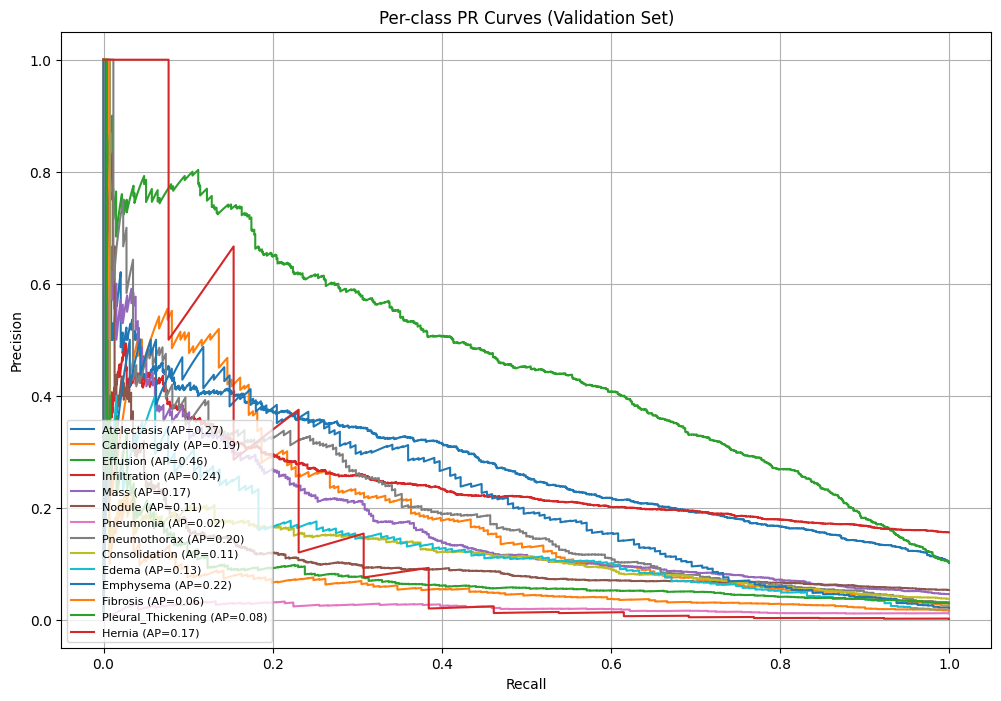

In [41]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curves(y_true, y_probs, class_names, title="Per-class PR curves"):
    plt.figure(figsize=(12, 8))
    
    for i, cls in enumerate(class_names):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
            ap = auc(recall, precision)
            plt.plot(recall, precision, label=f"{cls} (AP={ap:.2f})")
        except:
            continue

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left", fontsize=8)
    plt.grid(True)
    plt.show()


# ---- Plot PR curves for tuned thresholds model ----
all_probs, all_targets = [], []
raw_model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="PR curves data"):
        images = images.to(device)
        outputs = raw_model(images)
        all_probs.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

plot_pr_curves(all_targets, all_probs, class_names, title="Per-class PR Curves (Validation Set)")


In [42]:
# Collect per-class metrics into a DataFrame
def build_per_class_table(metrics_raw, metrics_tuned, metrics_calibrated, class_names):
    rows = []
    for cls in class_names:
        rows.append({
            "Class": cls,
            "Raw_AUROC": metrics_raw["per_class"][cls]["auroc"],
            "Raw_AUPRC": metrics_raw["per_class"][cls]["auprc"],
            "Raw_F1": metrics_raw["per_class"][cls]["f1"],
            "Tuned_AUROC": metrics_tuned["per_class"][cls]["auroc"],
            "Tuned_AUPRC": metrics_tuned["per_class"][cls]["auprc"],
            "Tuned_F1": metrics_tuned["per_class"][cls]["f1"],
            "Calib_AUROC": metrics_calibrated["per_class"][cls]["auroc"],
            "Calib_AUPRC": metrics_calibrated["per_class"][cls]["auprc"],
            "Calib_F1": metrics_calibrated["per_class"][cls]["f1"],
        })
    df = pd.DataFrame(rows)
    return df.round(3)


df_per_class = build_per_class_table(metrics_raw, metrics_tuned, metrics_calibrated, class_names)

display(df_per_class)


,Class,Raw_AUROC,Raw_AUPRC,Raw_F1,Tuned_AUROC,Tuned_AUPRC,Tuned_F1,Calib_AUROC,Calib_AUPRC,Calib_F1
0,Atelectasis,0.751,0.274,0.077,0.751,0.274,0.077,0.751,0.274,0.077
1,Cardiomegaly,0.831,0.190,0.239,0.831,0.190,0.239,0.831,0.190,0.239
2,Effusion,0.849,0.461,0.268,0.849,0.461,0.268,0.849,0.461,0.268
3,Infiltration,0.615,0.240,0.051,0.615,0.240,0.051,0.615,0.240,0.051
4,Mass,0.729,0.169,0.083,0.729,0.169,0.083,0.729,0.169,0.083
5,Nodule,0.627,0.109,0.025,0.627,0.109,0.025,0.627,0.109,0.025
6,Pneumonia,0.628,0.021,0.000,0.628,0.021,0.000,0.628,0.021,0.000
7,Pneumothorax,0.805,0.200,0.125,0.805,0.200,0.125,0.805,0.200,0.125
8,Consolidation,0.737,0.113,0.000,0.737,0.113,0.000,0.737,0.113,0.000
9,Edema,0.858,0.137,0.131,0.858,0.137,0.131,0.858,0.137,0.131
